## Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic

In [3]:
import pycuda.autoprimaryctx

Basically, we only need the context and stream

In [4]:
%cuda_context_handler gpu_ctx

In [5]:
import pycuda.driver as cuda
gpu_stream = cuda.Stream()

# Sampling GRF: FFT Approach

Use GPU for sampling random numbers (first step of immense speed-up)

In [6]:
nx = 10#630
ny = 5#315

In [7]:
from gpuocean.utils import Common

u_gpu = Common.CUDAArray2D(gpu_stream, nx, ny, 0, 0, np.zeros((ny,nx), dtype=np.float32))

In [8]:
from pycuda.curandom import XORWOWRandomNumberGenerator
rng = XORWOWRandomNumberGenerator()

In [9]:
rng.fill_normal(u_gpu.data, stream=gpu_stream)

In [10]:
u = u_gpu.download(gpu_stream)

In [11]:
u.shape

(5, 10)

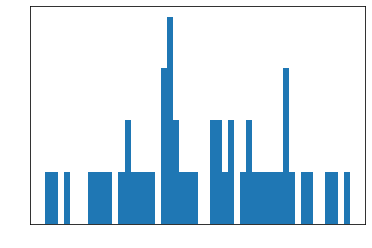

In [12]:
_ = plt.hist(u.flatten(), bins=50)

Only one row of distance matrix needed

In [13]:
dist = np.zeros((nx*ny))
for j in range(ny):
    for i in range(nx):
        dist[j*nx+i] = np.sqrt(i**2+j**2)
        dist[j*nx+i] = min([np.sqrt(i**2+j**2),np.sqrt((i-nx)**2+j**2),np.sqrt(i**2+(j-ny)**2),np.sqrt((i-nx)**2+(j-ny)**2)]) # only periodic!! Otherwise complex fft values!!

In [14]:
phi = 0.1
corr = np.exp(-phi*dist**2)

In [15]:
cov_toepitz = np.reshape(corr, (ny, nx))

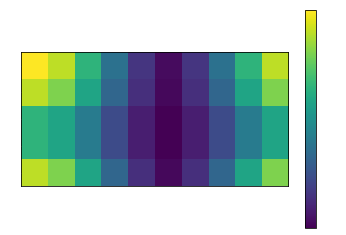

In [16]:
plt.imshow(cov_toepitz)
plt.colorbar()

## FFT on the CPU

In [17]:
# ctf = np.fft.fft2(cov_toepitz)
# ctfsm = np.sqrt(np.maximum(0,ctf))
# uf = np.fft.fft2(u)
# grf = np.fft.ifft2(ctfsm*uf).real

In [18]:
ctf = np.fft.rfft2(cov_toepitz)
ctfsm = np.sqrt(np.maximum(0,ctf))
uf = np.fft.rfft2(u)
grf = np.fft.irfft2(ctfsm*uf).real

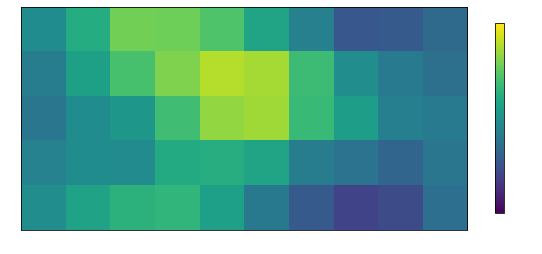

In [19]:
plt.figure(figsize=(10,5))
plt.imshow(grf, vmin=-2, vmax=2)
plt.colorbar(shrink=0.7)

##### Alternative code as in advectionDiffusion (same result upside down)

In [20]:
cmf = np.real(np.fft.fft2(cov_toepitz))
uif = np.fft.ifft2(u)
xf = np.real(np.fft.fft2(np.sqrt(np.maximum(cmf,0))*uif))

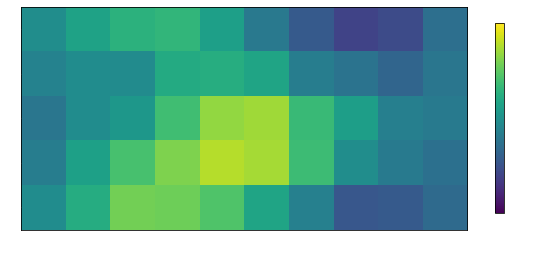

In [21]:
plt.figure(figsize=(10,5))
plt.imshow(xf, origin="lower", vmin=-2, vmax=2)
plt.colorbar(shrink=0.7)

## FFT via skcuda (2D!)

In [22]:
import numpy as np

import pycuda.driver as cuda
from pycuda.tools import make_default_context
import pycuda.gpuarray as gpuarray

In [23]:
from skcuda.fft import fft, ifft, Plan

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/skcuda/cublas.py:284: UserWarning: creating CUBLAS context to get version number
  warnings.warn('creating CUBLAS context to get version number')


##### Start with sanity checks

In [24]:
# https://forums.developer.nvidia.com/t/how-to-apply-scikit-cuda-2d-fft-pycuda/33055

data = np.random.randn(4,4)
print(data)

data_gpu = gpuarray.to_gpu(data.astype(np.float32))
out_gpu = gpuarray.empty(data.shape, np.complex64)

plan = Plan(data.shape, np.complex64, np.complex64)
fft(data_gpu, out_gpu, plan)
ifft(out_gpu, data_gpu, plan)

data_gpu.get()/np.product(data.shape)

[[ 0.23587117  0.26223236  0.6316631  -0.06556493]
 [ 1.75603489 -1.08832781  0.60210315 -1.94425511]
 [-0.46157348  0.57095756  0.61780114  1.49344211]
 [-0.06944917  0.8584152   0.04418086 -0.00581151]]


array([[-0.630041  ,  0.33764005,  0.00738998,  1.4071726 ],
       [ 0.630041  , -0.33764005, -0.00738998, -1.4071726 ],
       [-0.1960622 ,  0.        ,  0.        ,  0.7496268 ],
       [ 0.1960622 ,  0.        ,  0.        , -0.7496268 ]],
      dtype=float32)

In [25]:
# https://github.com/lebedov/scikit-cuda/issues/253
N = 4
array = np.random.randint(255, size=(N, N)).astype(np.float32)
print(array)
array_gpu = gpuarray.to_gpu(array)
ft = np.fft.fft2(array)
print(ft)

ft_gpu = gpuarray.empty((N//2+1, N//2+1), dtype=np.complex64)
plan = Plan((N, N), np.float32, np.complex64)
fft(array_gpu, ft_gpu, plan)
print(ft_gpu.get())


plan_inv = Plan((N, N), np.complex64, np.float32)
ifft(ft_gpu, array_gpu, plan_inv)
print(array)
print(array_gpu.get()/np.product(array_gpu.shape))

[[ 74. 237.  47.   2.]
 [ 20.  41. 100. 124.]
 [100. 161. 170.  10.]
 [ 51. 148. 228. 166.]]
[[1679.  +0.j -300.-285.j  -99.  +0.j -300.+285.j]
 [ -81.+308.j  162.-181.j -217. +10.j   32. -13.j]
 [ -77.  +0.j  214.-487.j   61.  +0.j  214.+487.j]
 [ -81.-308.j   32. +13.j -217. -10.j  162.+181.j]]
[[1679.  +0.j -300.-285.j  -99.  +0.j]
 [ -81.+308.j  162.-181.j -217. +10.j]
 [ -77.  +0.j  214.-487.j   61.  +0.j]]
[[ 74. 237.  47.   2.]
 [ 20.  41. 100. 124.]
 [100. 161. 170.  10.]
 [ 51. 148. 228. 166.]]
[[ 74. 237.  47.   2.]
 [ 20.  41. 100. 124.]
 [100. 161. 170.  10.]
 [ 51. 148. 228. 166.]]


##### Now, with RF from above

In [26]:
# https://www.idtools.com.au/gpu-accelerated-fft-compatible-with-numpy/
ct_gpu = gpuarray.to_gpu(cov_toepitz.astype(np.float32))
ctf_gpu = gpuarray.empty((ny//2+1, nx//2+1), np.complex64)
plan = Plan(ct_gpu.shape, np.float32, np.complex64)
fft(ct_gpu, ctf_gpu, plan)

In [27]:
ctf.real[0:ny//2+1,0:nx//2+1], ctf_gpu.real

(array([[ 2.26164451e+01,  9.20666009e+00,  9.81136172e-02,
          2.35391517e-01, -1.78852369e-01,  1.64078442e-01],
        [ 2.58636024e+00,  1.05285068e+00,  1.12200285e-02,
          2.69187866e-02, -2.04531107e-02,  1.87636013e-02],
        [-2.71252094e-01, -1.10420794e-01, -1.17673330e-03,
         -2.82318647e-03,  2.14507979e-03, -1.96788756e-03]]),
 array([[ 2.26164455e+01,  9.20666027e+00,  9.81135145e-02,
          2.35391587e-01, -1.78852320e-01,  1.64078474e-01],
        [ 2.58636045e+00,  1.05285072e+00,  1.12201069e-02,
          2.69187540e-02, -2.04531010e-02,  1.87638532e-02],
        [-2.71252424e-01, -1.10421054e-01, -1.17668614e-03,
         -2.82320986e-03,  2.14505964e-03, -1.96785852e-03]], dtype=float32))

In [28]:
# https://www.idtools.com.au/gpu-accelerated-fft-compatible-with-numpy/
u_gpu = gpuarray.to_gpu(u.astype(np.float32))
uf_gpu = gpuarray.empty((ny//2+1,nx//2+1), np.complex64)
plan = Plan(u_gpu.shape, np.float32, np.complex64)
fft(u_gpu, uf_gpu, plan)

In [29]:
uf_gpu

array([[  1.3215647 +0.j        ,  -3.2806842 -5.440156j  ,
          6.7786436 +4.5665913j ,  -0.6773279 -0.5146699j ,
         -1.2907424 -5.482617j  ,  -1.4060235 +0.j        ],
       [  0.01311387-5.8966384j ,   3.9027524 +1.4894857j ,
        -12.382043  -8.885874j  ,  -4.402953  +9.284044j  ,
          5.042242  -2.3212218j ,  10.522767  -0.97965705j],
       [ -8.9243145 +0.32170197j,  -6.799259  +1.632837j  ,
          3.1779692 +0.9987209j ,   2.4415948 -0.57684827j,
         -1.4342569 -3.3447495j ,   8.977766  -9.664736j  ]],
      dtype=complex64)

In [30]:
uf[0:ny//2+1,0:nx//2+1]

array([[  1.32156456+0.j        ,  -3.28068427-5.44015592j,
          6.77864333+4.56659117j,  -0.67732712-0.51467023j,
         -1.29074214-5.48261652j,  -1.4060232 +0.j        ],
       [  0.01311306-5.89663857j,   3.90275177+1.48948569j,
        -12.38204206-8.88587346j,  -4.40295316+9.28404315j,
          5.04224184-2.32122243j,  10.52276789-0.97965619j],
       [ -8.92431365+0.32170181j,  -6.7992585 +1.6328373j ,
          3.17796942+0.99872138j,   2.441595  -0.57684809j,
         -1.43425639-3.34474916j,   8.97776604-9.66473554j]])

In [31]:
# import pycuda.cumath as cumath
tmp_gpu = gpuarray.to_gpu((np.sqrt(np.maximum(ctf_gpu.get().real,0)) * uf_gpu.get()).astype(np.complex64))

grf_gpu = gpuarray.empty((ny,nx), np.float32)
plan_inv = Plan(grf_gpu.shape, np.complex64, np.float32)
ifft(tmp_gpu, grf_gpu, plan_inv)

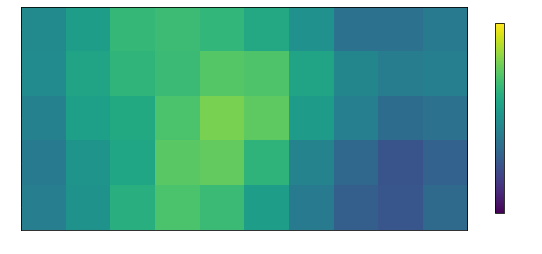

In [32]:
plt.figure(figsize=(10,5))
# ATTENTION: Inverse cuFFT needs scaling!
plt.imshow(grf_gpu.get()/nx/ny, vmin=-2, vmax=2)
plt.colorbar(shrink=0.7)

#### FFT via PyCuda Kernels (fails)

In [ ]:
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit

In [ ]:
import numpy
a = numpy.random.randn(4,4)
a = a.astype(numpy.float32)

a_gpu = cuda.mem_alloc(a.nbytes)
cuda.memcpy_htod(a_gpu, a)

mod = SourceModule("""
  __global__ void doublify(float *a)
  {
    int idx = threadIdx.x + threadIdx.y*4;
    a[idx] *= 2;
  }
  """)
#Allocate,generateandtransfer
func = mod.get_function("doublify")
func(a_gpu, block=(4,4,1))

a_doubled = numpy.empty_like(a)
cuda.memcpy_dtoh(a_doubled,a_gpu)
print(a, "\n\n", a_doubled)

In [ ]:
kernel = gpu_ctx.get_kernel("fft.cu")

In [ ]:
func = kernel.get_function("doublify")

In [ ]:
func.prepare("f")

In [ ]:
func.prepared_async_call((4,4),(1,1,1),gpu_stream, a)